## 90 Day Policy Analysis

To do:
- Confirm how data is being loaded in
- If using check_cache we will have to remove print statements from function
- Depending on what data source is being used, need to make sure that figures in text align with analysis outputs!!

In [1]:
#Loading packages
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt 
import os
import datetime as dt
import seaborn as sns
import duckdb as db
import statsmodels.api as sm
from requests import get
from urllib.parse import urlparse
from functools import wraps
from scipy.stats import chi2_contingency
from scipy.stats import ttest_rel
import statsmodels.formula.api as smf

In [2]:
#Function from practicals on downloading remote files and saving them locally:

def check_cache(f):
    @wraps(f)
    def wrapper(src, dst, min_size=100):
        url = urlparse(src) # We assume that this is some kind of valid URL 
        fn  = os.path.split(url.path)[-1] # Extract the filename
        dsn = os.path.join(dst,fn) # Destination filename
        if os.path.isfile(dsn) and os.path.getsize(dsn) > min_size:
            print(f"+ {dsn} found locally!")
            return(dsn)
        else:
            print(f"+ {dsn} not found, downloading!")
            return(f(src, dsn))
    return wrapper

@check_cache
def cache_data(src:str, dst:str) -> str:
    """Downloads a remote file.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dst : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """

    # Convert the path back into a list (without)
    # the filename -- we need to check that directories
    # exist first.
    path = os.path.split(dst)[0]
    print(f"Path: {path}")
      
    # Create any missing directories in dest(ination) path
    # -- os.path.join is the reverse of split (as you saw above)
    # but it doesn't work with lists... so I had to google how
    # to use the 'splat' operator! os.makedirs creates missing
    # directories in a path automatically.
    if path != '':
        os.makedirs(path, exist_ok=True)
        
    # Download and write the file
    with open(dst, "wb") as file:
        response = get(src)
        file.write(response.content)
        
    print(' + Done downloading...')

    return dst

In [3]:
#Or should it not cache and save locally? Reason being that this is intended to be only run once...

#Download London review data
review_url  = 'https://orca.casa.ucl.ac.uk/~jreades/data/20240614-London-reviews.csv.gz'
ddir = os.path.join('Documentation','data', 'raw') # destination directory
path  = cache_data(review_url, ddir)
reviews = pd.read_csv(path, compression='gzip')

#Download London listing data
listings_url = 'https://orca.casa.ucl.ac.uk/~jreades/data/20240614-London-listings.csv.gz'
path  = cache_data(listings_url, ddir)
listings = pd.read_csv(path, compression='gzip')

+ Documentation/data/raw/20240614-London-reviews.csv.gz found locally!
+ Documentation/data/raw/20240614-London-listings.csv.gz found locally!


In [4]:
#Select only desired listings columns
listings = listings[["id", "host_id", "room_type", "minimum_nights"]]

In [6]:
#Prepare reviews for analysis
reviews["date"] = pd.to_datetime(reviews["date"], format="%Y-%m-%d")
reviews['year'] = reviews.date.dt.year

In [7]:
#Filter reviews to desired time periods

#2015 to 2018 data for policy impact assessments
reviews_2015_2018 = reviews[(reviews.year > 2014) & (reviews.year < 2019)]

#Last 12 months data for quick statistic
max_date = reviews.date.max()
cutoff_2023 = max_date.replace(year=max_date.year - 1)
reviews_recent = reviews[reviews["date"] > cutoff_2023]

In [8]:
#Calculate estimated occupancy using Wang et al.'s (2024) methodology
#I tested a variety of metrics - this was the least conservative, but we have decided to use this one due to the logic behind it

#Findings have only been included in this write-up if they were similar for all metrics tested
#This is useful as a relative metric that can tell us direction of change, but due to the assumptions involved we shouldn't see it as an objective measure of absolute change

def occupancy_estimates(reviews,listings,year_columns):
    
    #Step 1: count reviews per listing per year
    reviews_annual = reviews.groupby(['listing_id', 'year']).size().unstack(fill_value=0)
    year_columns = {year: f'reviews_{year}' for year in year_columns}
    reviews_annual.rename(columns=year_columns, inplace=True)
    reviews_annual = reviews_annual.reset_index()
    reviews_annual.columns.name = None
    
    #Step 2: Divide each year by 0.5 (assume that 1 in 2 stays results in a review)
    for year in year_columns:
        reviews_annual[f'{year}_adjusted'] = reviews_annual[f'reviews_{year}'] / 0.5
        
    #Step 3: Join to the listings dataset
    #All listings are present for most recent 12 months, only 95% are present for 2015-2018 data - a limitation
    reviews_annual = reviews_annual.merge(listings, how='left', left_on='listing_id', right_on='id').drop(columns=['id'])
    reviews_annual.dropna(subset=['room_type'], inplace=True)

    #Step 4: Calculating estimated nights column: greater of either 3 (average stay according to Airbnb) or minimum nights
    reviews_annual['estimated_stay'] = np.maximum(3, reviews_annual.minimum_nights)

    #Step 5 and 6: 
    #5: Estimate occupied nights for each year by multiplying the adjusted review rate by the estimated stay duration (n.b. this assumes that the minimum nights has not changed over time)
    #6: Cap at 21 days per month (not changing 2016 leap year as 1/365 = 0.002...)
    cap_nights = 12 * 21  # max 21 days per month
    for year in year_columns:
        reviews_annual[f'estimated_nights{year}'] = reviews_annual[f'{year}_adjusted'] * reviews_annual.estimated_stay
        reviews_annual[f'estimated_nights{year}_capped'] = np.minimum(cap_nights, reviews_annual[f'estimated_nights{year}'])

    return reviews_annual

In [9]:
#Calculate estimates for 2015-2018 data
years = range(2015, 2019)

reviews_annual = occupancy_estimates(reviews_2015_2018,listings,years)
#reviews_annual.head()

In [10]:
# Prepare for two proportion z-test for change in proportions of room type between 2016 and 2017

# Reformat data
# Getting number of over 90s and totals for each category, as this is what the statistical test requires

#Calculating final table: whether a listing had True or False for over 90 days, and aggregated by room type
#Only looking at room type for now connected to research question, but I have the host column in there to check for superhosts if necessary

db.register('reviews_annual', reviews_annual)

query = '''
       WITH listings_90 AS (
            SELECT 
            listing_id,
            CASE WHEN room_type = 'Entire home/apt' THEN 'Entire Home' ELSE 'Other' END AS room_type,
            CASE WHEN estimated_nights2015_capped >= 90 THEN 1 ELSE 0 END AS over90_2015,
            CASE WHEN estimated_nights2015_capped BETWEEN 1 AND 90 THEN 1 ELSE 0 END AS under90_2015,
            CASE WHEN estimated_nights2016_capped >= 90 THEN 1 ELSE 0 END AS over90_2016,
            CASE WHEN estimated_nights2016_capped BETWEEN 1 AND 90 THEN 1 ELSE 0 END AS under90_2016,
            CASE WHEN estimated_nights2017_capped >= 90 THEN 1 ELSE 0 END AS over90_2017,
            CASE WHEN estimated_nights2017_capped BETWEEN 1 AND 90 THEN 1 ELSE 0 END AS under90_2017,
            CASE WHEN estimated_nights2018_capped >= 90 THEN 1 ELSE 0 END AS over90_2018,
            CASE WHEN estimated_nights2018_capped BETWEEN 1 AND 90 THEN 1 ELSE 0 END AS under90_2018
        FROM reviews_annual)
    SELECT
        room_type,
        SUM(over90_2015) AS over90_2015,
        SUM(over90_2015) + SUM(under90_2015) AS total_2015,
        SUM(over90_2016) AS over90_2016,
        SUM(over90_2016) + SUM(under90_2016) AS total_2016,
        SUM(over90_2017) AS over90_2017,
        SUM(over90_2017)+SUM(under90_2017) AS total_2017,
        SUM(over90_2018) AS over90_2018,
        SUM(over90_2018)+SUM(under90_2018) AS total_2018
    FROM listings_90
    GROUP BY 1
'''

proportions_room = db.sql(query).to_df()
#proportions_room.head()

In [11]:
# Two proportion z-test for proportions of property types above and below 90 days in 2016 and 2017
#Room type is independent and sample size is over 10 for each category
#https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportions_ztest.html

#H0: there is no difference in the proportion of properties estimated over 90 days for each room type.
#H1: there is a difference in the proportion of properties estimated over 90 days for each room type.

#Entire Home z-test
count_eh = [proportions_room[proportions_room.room_type=='Entire Home'].over90_2016,
               proportions_room[proportions_room.room_type=='Entire Home'].over90_2017]
nobs_eh = [proportions_room[proportions_room.room_type=='Entire Home'].total_2016,
              proportions_room[proportions_room.room_type=='Entire Home'].total_2017]

z_eh, p_eh = sm.stats.proportions_ztest(count_eh, nobs_eh)

#Other z-test
count_other = [proportions_room[proportions_room.room_type=='Other'].over90_2016,
               proportions_room[proportions_room.room_type=='Other'].over90_2017]
nobs_other = [proportions_room[proportions_room.room_type=='Other'].total_2016,
              proportions_room[proportions_room.room_type=='Other'].total_2017]

z_other, p_other = sm.stats.proportions_ztest(count_other, nobs_other)

#print(f"Z-statistic for 'Other' room type: {z_other}, P-value: {p_other}")
#print(f"Z-statistic for 'Entire Home' room type: {z_eh}, P-value: {p_eh}")

#Reject H0 for both
# Entire Home decrease is statistically significant at the 99% level
# Other increase is statistically significant at the 95% level

In [12]:
#Prepare for the two-proportion z-test in proportion of properties estimated over 90 days for each host type

#Getting number of over 90s and totals for each category, as this is what the statistical test requires

query2 = '''
       WITH host_type AS (
       SELECT 
           host_id,
           CASE WHEN COUNT(*)>1 THEN 'Multi-Listing Host' ELSE 'Single Property Host' END AS host_type           
       FROM reviews_annual
       GROUP BY 1),
       
       listings_90 AS (
            SELECT 
            r.listing_id,
            h.host_type,
            CASE WHEN r.estimated_nights2015_capped >= 90 THEN 1 ELSE 0 END AS over90_2015,
            CASE WHEN r.estimated_nights2015_capped BETWEEN 1 AND 90 THEN 1 ELSE 0 END AS under90_2015,
            CASE WHEN r.estimated_nights2016_capped >= 90 THEN 1 ELSE 0 END AS over90_2016,
            CASE WHEN r.estimated_nights2016_capped BETWEEN 1 AND 90 THEN 1 ELSE 0 END AS under90_2016,
            CASE WHEN r.estimated_nights2017_capped >= 90 THEN 1 ELSE 0 END AS over90_2017,
            CASE WHEN r.estimated_nights2017_capped BETWEEN 1 AND 90 THEN 1 ELSE 0 END AS under90_2017,
            CASE WHEN r.estimated_nights2018_capped >= 90 THEN 1 ELSE 0 END AS over90_2018,
            CASE WHEN r.estimated_nights2018_capped BETWEEN 1 AND 90 THEN 1 ELSE 0 END AS under90_2018
        FROM reviews_annual r
            LEFT JOIN host_type h
                ON r.host_id=h.host_id)
        
    SELECT
        host_type,
        SUM(over90_2015) AS over90_2015,
        SUM(over90_2015) + SUM(under90_2015) AS total_2015,
        SUM(over90_2016) AS over90_2016,
        SUM(over90_2016) + SUM(under90_2016) AS total_2016,
        SUM(over90_2017) AS over90_2017,
        SUM(over90_2017)+SUM(under90_2017) AS total_2017,
        SUM(over90_2018) AS over90_2018,
        SUM(over90_2018)+SUM(under90_2018) AS total_2018
    FROM listings_90
    GROUP BY 1
'''

proportions_host = db.sql(query2).to_df()
#proportions_host.head()

In [13]:
#Two proportion z-test in proportion of properties estimated over 90 days for each host type.

#H0: there is no difference in the proportion of properties estimated over 90 days for each host type.
#H1: there is a difference in the proportion of properties estimated over 90 days for each host type.

#Superhost z-test
count_m = [proportions_host[proportions_host.host_type=='Multi-Listing Host'].over90_2016,
               proportions_host[proportions_host.host_type=='Multi-Listing Host'].over90_2017]
nobs_m = [proportions_host[proportions_host.host_type=='Multi-Listing Host'].total_2016,
              proportions_host[proportions_host.host_type=='Multi-Listing Host'].total_2017]

z_m, p_m = sm.stats.proportions_ztest(count_m, nobs_m)

#Single property host z-test
count_s = [proportions_host[proportions_host.host_type=='Single Property Host'].over90_2016,
               proportions_host[proportions_host.host_type=='Single Property Host'].over90_2017]
nobs_s = [proportions_host[proportions_host.host_type=='Single Property Host'].total_2016,
              proportions_host[proportions_host.host_type=='Single Property Host'].total_2017]

z_s, p_s = sm.stats.proportions_ztest(count_s, nobs_s)

#print(f"Z-statistic for Multi-Listing Hosts: {z_m}, P-value: {p_m}")
#print(f"Z-statistic for Single Property Hosts: {z_s}, P-value: {p_s}")

# Multi-listing host decrease is statistically significant at the 99% level - reject H0
# Single property host had no statistically significant change - accept H0

In [14]:
#Difference in differences test
#Linking to this as I drew on it a lot: #https://www.kaggle.com/code/harrywang/difference-in-differences-in-python

#Extracting relevant columns:
did_df = reviews_annual[["listing_id", "room_type", "estimated_nights2015_capped", "estimated_nights2016_capped", "estimated_nights2017_capped", "estimated_nights2018_capped"]].copy()

#Create a column for over 90 or not
for year in years:
    did_df[f'over_90_{year}'] = (did_df[f'estimated_nights{year}_capped'] > 90).astype(int)

#Create treatment (Entire Home) versus control (Other) group
did_df['entire_home'] = (did_df.room_type == 'Entire home/apt').astype(int)

#Pivoting data - ChatGPT helped
did_df = did_df.melt(
    id_vars=['listing_id', 'room_type', 'entire_home'], 
    value_vars=[f'over_90_{year}' for year in years], 
    var_name='year', 
    value_name='over_90'
)

#Extract year (final 4 characters)
did_df['year'] = did_df.year.str[-4:].astype(int)

#Policy and interaction columns
did_df['post_policy'] = (did_df.year >= 2017).astype(int)
did_df['interaction'] = did_df.entire_home * did_df.post_policy

#Run model
did_rooms = smf.ols('over_90 ~ post_policy + entire_home + interaction', data=did_df).fit()
#did_rooms.summary()

#Low goodness of fit (R^2 is 0.024)
#But statistically significant decrease (-0.0476, or 4.76%) in Entire Homes available over 90 days

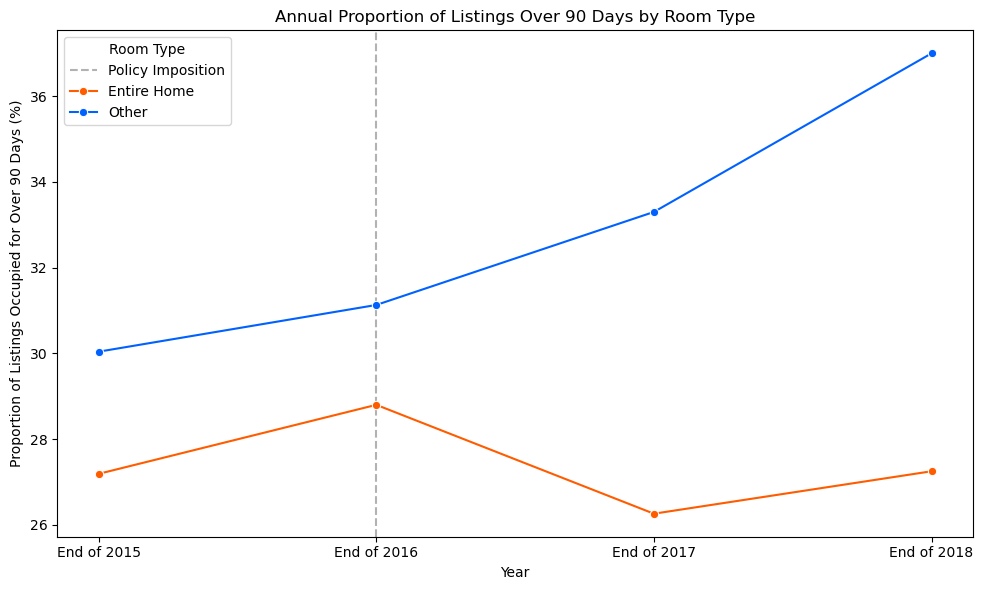

In [15]:
#Plotting change over time

#Quickly calculate proportions of room types over time
db.register('proportions_room', proportions_room)
query3 = '''
        SELECT room_type,
               ROUND(100 * over90_2015/total_2015, 2) AS pct_90_2015,
               ROUND(100 * over90_2016/total_2016, 2) AS pct_90_2016,
               ROUND(100 * over90_2017/total_2017, 2) AS pct_90_2017,
               ROUND(100 * over90_2018/total_2018, 2) AS pct_90_2018
        FROM proportions_room
        '''
room_proportions = db.sql(query3).to_df()

#Pivot this - ChatGPT helped with the melt method
rooms_pivoted = room_proportions.melt(id_vars='room_type', 
                                  value_vars=['pct_90_2015', 'pct_90_2016', 'pct_90_2017', 'pct_90_2018'], 
                                  var_name='Year', 
                                  value_name='Proportion Over 90 Days')

#Format the year column
rooms_pivoted['Year'] = rooms_pivoted.Year.str[-4:].astype(int)

#Set up figure

#Figure
colours = {'Entire Home': '#ff5c00', 'Other': '#0061ff'}
plt.figure(figsize=(10, 6))
plt.axvline(x=2016, color='grey', alpha=0.6, linestyle='--', label='Policy Imposition')
sns.lineplot(data=rooms_pivoted, x='Year', y='Proportion Over 90 Days', hue='room_type', marker='o', palette=colours)

#Labels
plt.title('Annual Proportion of Listings Over 90 Days by Room Type')
plt.xlabel('Year')
plt.ylabel('Proportion of Listings Occupied for Over 90 Days (%)')
plt.legend(title='Room Type')

#Sort out x-ticks: add Dec to make it clear it's for cumulative year (rather than Jan)
xticks = years
xticklabels = [f'End of {year}' for year in xticks]
plt.xticks(xticks, xticklabels)

plt.tight_layout()
plt.show()

In [16]:
#Get occupancy estimates for the past 12 months
reviews_recent.loc[:, 'year'] = 2024 #this is false but setting it so the function will work

reviews_24 = occupancy_estimates(reviews_recent, listings, [2024])

In [18]:
#Work out percentage estimated over 90 days

db.register('reviews_24', reviews_24)

query4 = '''
       WITH listings_90 AS (
            SELECT 
            listing_id,
            CASE WHEN room_type = 'Entire home/apt' THEN 'Entire Home' ELSE 'Other' END AS room_type,
            CASE WHEN estimated_nights2024_capped >= 90 THEN 1 ELSE 0 END AS over90_2023_24,
            CASE WHEN estimated_nights2024_capped BETWEEN 1 AND 90 THEN 1 ELSE 0 END AS under90_2023_24
        FROM reviews_24),

        totals AS (
            SELECT
            room_type,
            SUM(over90_2023_24) AS over90_2023_24,
            SUM(over90_2023_24) + SUM(under90_2023_24) AS total_2023_24
            FROM listings_90
            GROUP BY 1)

        SELECT 
            room_type,
            ROUND(100 * SUM(over90_2023_24) / SUM(total_2023_24), 2) AS pct_over90
        FROM totals
        GROUP BY 1
'''

recent_proportions = db.sql(query4).to_df()
#recent_proportions.head()

#Percent estimated over 90 days is 23.75% for Entire Home, as opposed to 34.39% for Other
#Obviously the proportion itself doesn't matter as much as changes in the proportion (because we are very uncertain about the metric itself)
#But this figure for Entire Homes is lower than in 2017, indicating the policy is still having an impact

,room_type,pct_over90
0,Entire Home,23.75
1,Other,34.39


In [19]:
#Paired sample t-test for listings per host between 2016 and 2017

#H0: there is no difference in the number of listings for the same hosts in 2017 versus 2016
#H1: there is a difference in the number of listings for the same hosts in 2017 versus 2016

#Getting listings count per host for all hosts who had at least 1 active listing in 2016 and 2017
#This is a paired sample t-test so they have to be in both
query5 = '''
        WITH counts AS (
            SELECT
                DISTINCT(host_id),
                SUM(CASE WHEN reviews_2016 > 0 THEN 1 ELSE 0 END) AS listings_2016,
                SUM(CASE WHEN reviews_2017 > 0 THEN 1 ELSE 0 END) AS listings_2017
            FROM reviews_annual 
            GROUP BY 1)
        SELECT *
        FROM counts
        WHERE listings_2016 > 0 AND listings_2017>0
        '''
host_listing_counts = db.sql(query5).to_df()

t_stat, p_value = ttest_rel(host_listing_counts.listings_2016, host_listing_counts.listings_2017)
#print(f"t-statistic: {t_stat}, p-value: {p_value}")

#print(f'Mean listing count in 2016: {host_listing_counts.listings_2016.mean():.2f}')
#print(f'Mean listing count in 2017: {host_listing_counts.listings_2017.mean():.2f}')

#t-statistic: -7.901495258088523, p-value: 3.4601936865191537e-15
#Mean listing count in 2016: 1.23
#Mean listing count in 2017: 1.36

#So count of listings per host increased between years

In [20]:
#Adding Edinburgh data for hosts DiD
edi_review_url = 'https://raw.githubusercontent.com/iantsern-twuk/CASA0013_FSDS_Airbnb-data-analytics/refs/heads/main/Documentation/data/edinburgh/reviews.csv'
ddir = os.path.join('Documentation','data', 'edinburgh')
path  = cache_data(edi_review_url, ddir)
edi_reviews = pd.read_csv(path)

edi_listing_url = 'https://raw.githubusercontent.com/iantsern-twuk/CASA0013_FSDS_Airbnb-data-analytics/refs/heads/main/Documentation/data/edinburgh/listings.csv'
path  = cache_data(edi_listing_url, ddir) #same ddir
edi_listings = pd.read_csv(path)

+ Documentation/data/edinburgh/reviews.csv found locally!
+ Documentation/data/edinburgh/listings.csv found locally!


In [21]:
#Prepare for analysis: same data cleaning and filtering steps as above

edi_reviews["date"] = pd.to_datetime(edi_reviews["date"], format="%Y-%m-%d")
edi_reviews['year'] = edi_reviews.date.dt.year
edi_reviews_2015_2018 = edi_reviews[(edi_reviews.year > 2014) & (edi_reviews.year < 2019)]

edi_listings = edi_listings[["id", "host_id", "room_type", "minimum_nights"]]

In [22]:
#Calculate estimated occupancies
#Use same list of years as for London data
edi_reviews_annual = occupancy_estimates(edi_reviews_2015_2018,edi_listings,years)

In [23]:
#Find distinct listings for both locations
tables = ['reviews_annual', 'edi_reviews_annual']
results = []

# Loop through each table and process
for table_name in tables:

    #Set treatment flag before combining tables
    london_flag = 1 if table_name == 'reviews_annual' else 0

    query = f'''
    SELECT
        DISTINCT(host_id),
        SUM(CASE WHEN reviews_2015 > 0 THEN 1 ELSE NULL END) AS listings_2015,
        SUM(CASE WHEN reviews_2016 > 0 THEN 1 ELSE NULL END) AS listings_2016,
        SUM(CASE WHEN reviews_2017 > 0 THEN 1 ELSE NULL END) AS listings_2017,
        SUM(CASE WHEN reviews_2018 > 0 THEN 1 ELSE NULL END) AS listings_2018
    FROM {table_name}
    GROUP BY 1
    '''
    # Execute query and get result as DataFrame
    output = db.sql(query).to_df()

    # Add the treatment column
    output['london'] = london_flag

    # Append to results list
    results.append(output)

# Combine results from both tables
distinct_hosts = pd.concat(results, ignore_index=True)

In [24]:
#Comparison of counts

db.register('distinct_hosts', distinct_hosts)

query7 = '''
        SELECT 
            CASE WHEN london = 1 THEN 'London' ELSE 'Edinburgh' END AS city,
            ROUND(AVG(listings_2015), 2) AS avg_listings_2015,
            ROUND(AVG(listings_2016),2) AS avg_listings_2016,
            ROUND(AVG(listings_2017),2) AS avg_listings_2017,
            ROUND(AVG(listings_2018),2) AS avg_listings_2018
        FROM distinct_hosts 
        GROUP BY 1
        '''
check = db.sql(query7).to_df()
#check.head()

#London has increased relatively greater than Edinburgh every year, but particularly between 2016-2017 and 2017-2018

In [25]:
#Pivot data for DiD

#ChatGPT helped again with the melt method
combined_did = pd.melt(
    distinct_hosts,
    id_vars=['host_id', 'london'], 
    value_vars=['listings_2015', 'listings_2016', 'listings_2017', 'listings_2018'],
    var_name='year', 
    value_name='count_listings')

In [26]:
#Finish setting up df

#Extract year
combined_did['year'] = combined_did.year.str[-4:].astype(int)

#Policy and interaction columns
combined_did['post_policy'] = (combined_did.year >= 2017).astype(int)
combined_did['interaction'] = combined_did.london * combined_did.post_policy

In [27]:
#Run model
did_listings = smf.ols('count_listings ~ post_policy + london + interaction', data=combined_did).fit()
#did_listings.summary()

#Interaction is not statistically significant!
#But coefficient (0.0689) would have implied it led to an increase - potentially cancelling drop in proportion over 90 days out?

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         count_listings   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     18.39
Date:                Mon, 16 Dec 2024   Prob (F-statistic):           6.48e-12
Time:                        22:39:43   Log-Likelihood:                -52686.
No. Observations:               31612   AIC:                         1.054e+05
Df Residuals:                   31608   BIC:                         1.054e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.2780      0.042     30.682      0.000       1.196       1.360
post_policy     0.0398      0.051      0.783      0.434      -0.060       0.140
london         -0.1162      0.044     -2.663      0.008      -0.202      -0.031
interaction     0.0689      0.053      1.291      0.197      -0.036       0.173
==============================================================================
Omnibus:                    78777.822   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2106303233.251
Skew:                          26.952   Prob(JB):                         0.00
Kurtosis:                    1266.412   Cond. No.                         21.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""